# Graph-based Data Integration Methods

The network $G=(V,E)$ represents cell samples from patients. The vertices $V$ correspond to the patients $\{x_1,x_2,...,x_n\}$ and the edges are weighted by how similar the samples from these patients are.

The following two **network-based integration** methods are examined:

- Similarity Network Fusion (Wang et al., 2014)
- Affinity Network Fusion (Zhang et al., 2018))

## 1. Multi-Omics Dataset

In [1]:
import pickle
import pandas as pd
import numpy as np

import networkx as nx
from tqdm import tqdm

from numpy.linalg import eig
from scipy.sparse.csgraph import laplacian

import networkx.algorithms.community as nx_comm
from networkx.algorithms.community.quality import partition_quality

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [2]:
# cells that are selected for multi-omics modeling
cells = pd.read_csv('../data/cells.csv', index_col='CCLE_ID')

In [3]:
genes = pd.read_csv('../data/omics/genes.csv', index_col='CCLE_ID')
genes.columns

Index(['5S_rRNA', '7SK', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1',
       'A2ML1-AS1', 'A2ML1-AS2',
       ...
       'snoZ13_snr52', 'snoZ178', 'snoZ185', 'snoZ247', 'snoZ40', 'snoZ5',
       'snoZ6', 'snosnR60_Z15', 'snosnR66', 'yR211F11.2'],
      dtype='object', length=54271)

In [4]:
metabolites = pd.read_csv('../data/omics/metabolites.csv', index_col='CCLE_ID')
metabolites.columns

Index(['2-aminoadipate', '3-phosphoglycerate', 'alpha-glycerophosphate',
       '4-pyridoxate', 'aconitate', 'adenine', 'adipate',
       'alpha-ketoglutarate', 'AMP', 'citrate',
       ...
       'C56:8 TAG', 'C56:7 TAG', 'C56:6 TAG', 'C56:5 TAG', 'C56:4 TAG',
       'C56:3 TAG', 'C56:2 TAG', 'C58:8 TAG', 'C58:7 TAG', 'C58:6 TAG'],
      dtype='object', length=225)

In [5]:
mirnas = pd.read_csv('../data/omics/mirnas.csv', index_col='CCLE_ID')
mirnas.columns

Index(['hsa-let-7a', 'hsa-let-7b', 'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e',
       'hsa-let-7f', 'hsa-let-7g', 'hsa-let-7i', 'hsa-miR-1', 'hsa-miR-100',
       ...
       'kshv-miR-K12-4-3p', 'kshv-miR-K12-4-5p', 'kshv-miR-K12-5',
       'kshv-miR-K12-6-3p', 'kshv-miR-K12-6-5p', 'kshv-miR-K12-7',
       'kshv-miR-K12-8', 'kshv-miR-K12-9', 'mcv-miR-M1-3p', 'mcv-miR-M1-5p'],
      dtype='object', length=734)

## 2. Similarity Network Fusion

Wang et al. (2014) introduced similarity network fusion to combine different data types from multi-omics sources. The **kernel function** $K(i,j)$ is said to be less sensitive to changes in the parameters $\gamma$ and $\sigma$.
1. calculates kernel $K(i,j)$ between all neighbors of each node
2. where the scale of the kernel is determined by the hyperparameter $\gamma$
3. normalizes the similarity by using k-nearest neighbors $N_i$

In [6]:
from snf import snf, make_affinity

views = [genes.values, metabolites.values, mirnas.values]
W_v = make_affinity(views, metric='euclidean', K=20, mu=0.5)

W = snf(W_v, K=20, t=2)

In this notebook the Python implementation by [@rmarkello](https://github.com/rmarkello/snfpy) is used.

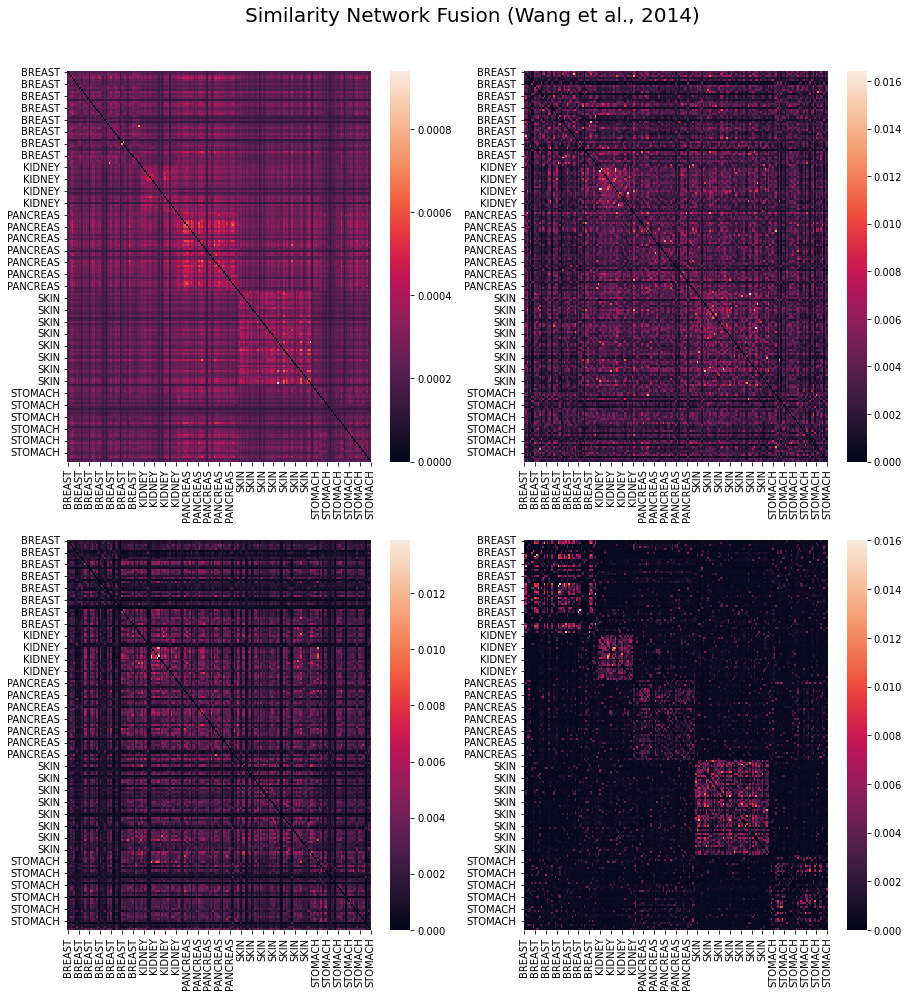

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

fig.suptitle('Similarity Network Fusion (Wang et al., 2014)', fontsize=20)
sites = ['STOMACH', 'BREAST', 'PANCREAS', 'KIDNEY', 'SKIN']

def show_by_primary_site(W, sites):
    S = W
    np.fill_diagonal(S, 0.0)
    data = pd.DataFrame(S, index=cells.primary_site.values, columns=cells.primary_site.values)

    data = data.loc[sites][sites]
    data = data.sort_index().transpose().sort_index()

    return data

sns.heatmap(show_by_primary_site(W_v[0], sites), ax=axs[0][0])
sns.heatmap(show_by_primary_site(W_v[1], sites), ax=axs[0][1])
sns.heatmap(show_by_primary_site(W_v[2], sites), ax=axs[1][0])
sns.heatmap(show_by_primary_site(W, sites), ax=axs[1][1])

fig.subplots_adjust(top=0.92)
plt.show()

## 3. Affinity Network Fusion

Zhang & Ma (2018) proposed affinity network fusion as a method which is meant to reduce and simplify SNF, while still producing a reliable network.

1. calculates Gaussian kernel $K(i,j)$ between $k$ nearest neighbors
2. parameters $\alpha$ and $\beta$ can be adjusted to prevent over-/underfitting

In [3]:
# pre-computed using official R code
W = pd.read_csv("../data/anf/fused.txt", sep=" ")
W_v1 = pd.read_csv("../data/anf/genes.txt", sep=" ")
W_v2 = pd.read_csv("../data/anf/metabolites.txt", sep=" ")
W_v3 = pd.read_csv("../data/anf/micrornas.txt", sep=" ")

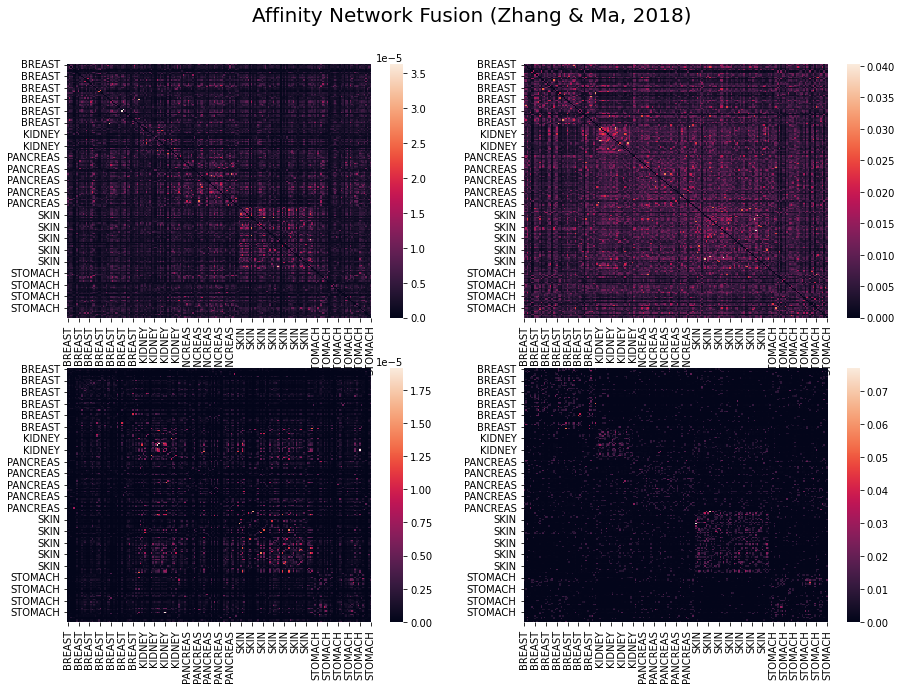

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

fig.suptitle('Affinity Network Fusion (Zhang & Ma, 2018)', fontsize=20)
sites = ['STOMACH', 'BREAST', 'PANCREAS', 'KIDNEY', 'SKIN']

def show_by_primary_site(W, sites):
    S = W.values
    np.fill_diagonal(S, 0.0)
    data = pd.DataFrame(S, index=cells.primary_site.values, columns=cells.primary_site.values)

    data = data.loc[sites][sites]
    data = data.sort_index().transpose().sort_index()

    return data

sns.heatmap(show_by_primary_site(W_v1, sites), ax=axs[0][0])
sns.heatmap(show_by_primary_site(W_v2, sites), ax=axs[0][1])
sns.heatmap(show_by_primary_site(W_v3, sites), ax=axs[1][0])
sns.heatmap(show_by_primary_site(W, sites), ax=axs[1][1])

fig.subplots_adjust(top=0.90)
plt.show()

## 4. Prepare for Machine Learning Tasks

We need to clean the network representation of the dataset and add important information about **cancer histology** and **subtype** to the nodes. As we want to enable instance-based learning tasks, we need to save the network with **node features** and **edge weights**.

In [8]:
# load cell-line drug sensitivity data
drugs = pd.read_csv('../data/drugs.csv')

sensitivity = drugs.pivot_table(values='area_under_curve', index='cpd_name', columns='ccl_name')

In [9]:
# set vertex label of each node to its id 
node_labels = cells.id.reset_index(drop=True)
node_attrs = cells.reset_index(drop=True).set_index('id')

In [10]:
# add histology & subtype information to the node attributes
info = drugs[['ccl_name', 'ccle_primary_site', 'ccle_primary_hist', 'ccle_hist_subtype_1']]
info = info.drop_duplicates().set_index('ccl_name')

cell_attrs = node_attrs.join(info)
cell_attrs = cell_attrs.drop(columns=['ccle_primary_site'])

In [11]:
# drug sensitivity from cell viability screens
drug_attrs = sensitivity.transpose()[['doxorubicin']]

In [12]:
# combined attributes for all samples
node_table = cell_attrs.join(drug_attrs)

# handle NaN value for drug sensitvity and subtype
node_table = node_table.replace(np.nan,"nan", regex=True)

node_table.head()

,primary_site,ccle_primary_hist,ccle_hist_subtype_1,doxorubicin
22RV1,PROSTATE,carcinoma,nan,6.001
2313287,STOMACH,carcinoma,adenocarcinoma,6.6801
253J,URINARY_TRACT,carcinoma,transitional_cell_carcinoma,7.5252
253JBV,URINARY_TRACT,carcinoma,transitional_cell_carcinoma,8.926
42MGBA,CENTRAL_NERVOUS_SYSTEM,glioma,astrocytoma_Grade_IV,8.5321


In [13]:
def affinity_graph(A, labels, attrs=None):

    # from numpy adjacency
    G = nx.from_numpy_array(A)
    G = nx.relabel_nodes(G, labels.to_dict())

    for column in attrs:
        nx.set_node_attributes(G, attrs[column].to_dict(), column)

    return G

Using the **node table** and the **adjacency matrix** we can use networkx to construct a graph representation of our data.

In [14]:
# fused matrix W and node_table with sample attributes
G = affinity_graph(W.values, node_labels, attrs=node_table)

In [15]:
# save this network for machine learning tasks
nx.write_gexf(G,'../graphs/affinity_network.gexf')

The process is summarized in this Python script [graph.py](../graph.py), which can be used to run experiments.

## 5. Analyse the Affinity Networks

The labels are considered to evaluate partitioning performance and to optimize $\alpha$, $\beta$ and $\gamma$. 

### Which distance metric are we using for omics data?

Affinity Network Fusion for instance is using the Gaussian kernel to transform the distance between samples into a similarity measurement between them. If we assume the input distribution of values to be iid random variables, then their **euclidean distance** follows a **$\chi$-squared** distribution. For large degrees of freedom this approximates the normal distribution. Hence, in theory the Gaussian kNN kernel should be a more appropriate measure.

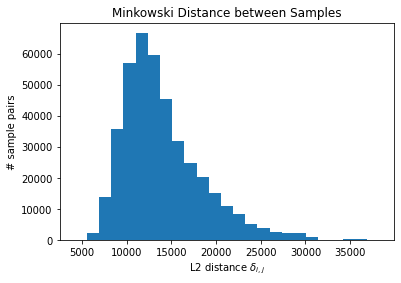

In [16]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

distances = pdist(genes.values, metric='minkowski', p=2)
dist_matrix = squareform(distances)

plt.title('Minkowski Distance between Samples')
plt.hist(distances, bins=25)
plt.ylabel('# sample pairs')
plt.xlabel('L2 distance $\delta_{i,j}$')
plt.show()

The above experiment shows the distribution of $\delta_{i,j}$ between the samples in the dataset.

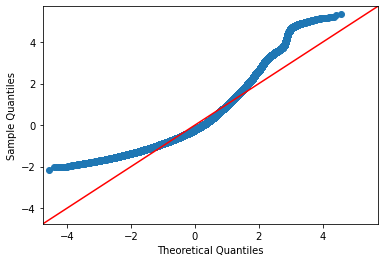

In [17]:
import statsmodels.api as sm

standardized = (distances - distances.mean())/distances.std()

sm.qqplot(standardized, line='45')
plt.show()

### How do we evaluate the similarity graph's performance?

The smallest non-zero eigenvalue $\lambda_1$ of the laplacian $L=W-D$, is the algebraic connectivity of the graph [\[fiedler '73\]](https://dml.cz/bitstream/handle/10338.dmlcz/101168/CzechMathJ_23-1973-2_11.pdf).

The conductance $\Phi_G$ of a graph is bound by $\lambda_1$ according to Cheeger's inequality: $\frac{1}{2}\lambda_1 \leq \Phi_G \leq \sqrt{2\lambda_1}$ [\[alon '86\]](https://link.springer.com/content/pdf/10.1007/BF02579166.pdf).

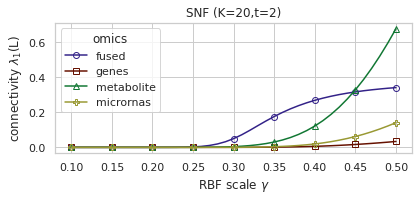

In [3]:
plt.figure(figsize=(6.4,2.4))
plt.title('SNF (K=20,t=2)')

with open('../results/gammas_SNF.pkl', 'rb') as f:
    gammas = pickle.load(f)

with open('../results/lambda_1_gamma_SNF.pkl', 'rb') as f:
    lambda_1_SNF = pickle.load(f)

with open('../results/lambda_1_gene_SNF.pkl', 'rb') as f:
    lambda_1_gene_SNF = pickle.load(f)

with open('../results/lambda_1_metabolites_SNF.pkl', 'rb') as f:
    lambda_1_metabolites_SNF = pickle.load(f)

with open('../results/lambda_1_micrornas_SNF.pkl', 'rb') as f:
    lambda_1_micrornas_SNF = pickle.load(f)

# Cheeger's inequalities
lower = [lamb/2 for lamb in lambda_1_SNF]
upper = [np.sqrt(1*lamb) for lamb in lambda_1_SNF]

#plt.fill_between(x=gammas,y1=lower,y2=upper, hatch='\\', alpha=0.25)
plt.plot(gammas[:-10], lambda_1_SNF[:-10], '-', color="#332288", marker='o', markevery=5, markerfacecolor="None", label='fused')

lower = [lamb/2 for lamb in lambda_1_gene_SNF]
upper = [np.sqrt(1*lamb) for lamb in lambda_1_gene_SNF]

#plt.fill_between(x=gammas,y1=lower,y2=upper, hatch='//', alpha=0.25)
plt.plot(gammas[:-10], lambda_1_gene_SNF[:-10], '-', color="#661100", marker='s', markevery=5, markerfacecolor="None", label='genes')

plt.plot(gammas[:-10], lambda_1_metabolites_SNF[:-10], '-', marker='^', color="#117733", markevery=5, markerfacecolor="None", label='metabolite')

lower = [lamb/2 for lamb in lambda_1_micrornas_SNF]
upper = [np.sqrt(1*lamb) for lamb in lambda_1_micrornas_SNF]

#plt.fill_between(x=gammas,y1=lower,y2=upper, hatch='.', alpha=0.25)
plt.plot(gammas[:-10], lambda_1_micrornas_SNF[:-10], '-', color="#999933", marker='P', markevery=5, markerfacecolor="None", label='micrornas')

plt.ylabel('connectivity $\lambda_1$(L)')
plt.xlabel('RBF scale $\gamma$')
plt.legend(title='omics')
plt.savefig('../figures/SNF_scale_K=20_t=2_gamma.png', dpi=500, bbox_inches='tight')
plt.show()

We can measure the **modularity** of a graph given the external information about the subtypes. However, we need to be careful, as sparse graphs tend to have higher modularity. Hence, it is better to consider both, *how connected the graphs are and how well they fit the labels in terms of modularity*.

$$Q = \sum_{c=1}^{n} \left[ \frac{L_c}{m} - \left(\frac{k_c}{2m}\right)^2 \right]$$

$L_c$ is the number of links within a cluster, $m$ is the toatl number of edges and $k_c$ is the sum of degrees for the nodes in that cluster.

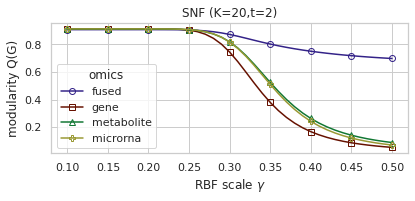

In [4]:
plt.figure(figsize=(6.4,2.4))
plt.title('SNF (K=20,t=2)')

with open('../results/gammas_SNF.pkl', 'rb') as f:
    gammas = pickle.load(f)
with open('../results/Q_gammas_SNF.pkl', 'rb') as f:
    Q = pickle.load(f)
with open('../results/modularity_gene_SNF.pkl', 'rb') as f:
    Q2 = pickle.load(f)
with open('../results/modularity_metabolite_SNF.pkl', 'rb') as f:
    Q3 = pickle.load(f)
with open('../results/modularity_microrna_SNF.pkl', 'rb') as f:
    Q4 = pickle.load(f)

plt.plot(gammas[:-10], Q[:-10], '-', marker='o', color="#332288", markevery=5, markerfacecolor="None", label='fused')
plt.plot(gammas[:-10], Q2[:-10], '-', marker='s', color="#661100", markevery=5, markerfacecolor="None", label='gene')
plt.plot(gammas[:-10], Q3[:-10], '-', marker='^', color="#117733", markevery=5, markerfacecolor="None", label='metabolite')
plt.plot(gammas[:-10], Q4[:-10], '-', marker='P', color="#999933", markevery=5, markerfacecolor="None", label='microrna')

plt.ylabel('modularity Q(G)')
plt.xlabel('RBF scale $\gamma$')
plt.legend(title='omics')
plt.savefig('../figures/SNF_modularity_K=20_t=2_gamma.png', dpi=500, bbox_inches='tight')
plt.show()

### How does the local diameter $\alpha$ and pairwise distance $\beta$ influence the affinity network?

/home/ramon/Desktop/DKE Bachelor Thesis/thesis/lib/python3.9/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


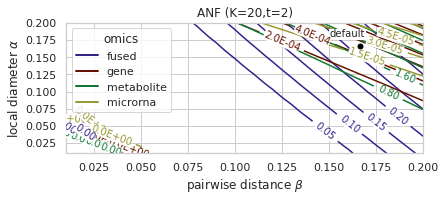

In [46]:
plt.figure(figsize=(6.4,2.4))
plt.title('ANF (K=20,t=2)')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#332288", lw=2),
                Line2D([0], [0], color="#661100", lw=2),
                Line2D([0], [0], color="#117733", lw=2),
                Line2D([0], [0], color="#999933", lw=2)]

index = alphas * len(betas)

data = pd.melt(parameters, var_name='beta').set_index(pd.Series(index))
data.index = data.index.set_names(['alpha'])
data = data.reset_index()

cs = plt.contour(betas,alphas,parameters.values, colors="#332288")
cs_gene = plt.contour(betas,alphas,parameters_gene.values, colors="#661100")
cs_metabolite = plt.contour(betas,alphas,parameters_metabolite.values, colors="#117733")
cs_microrna = plt.contour(betas,alphas,parameters_microrna.values, colors="#999933")
cgene = plt.clabel(cs_gene, cs_gene.levels, inline=True, manual=[(0.0, 0.2), (0.125,0.175), (0.14,0.175), (0.0,0.0), (0.0,0.0), (0.0,0.0)], fmt='%.1E', fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cgene]
cmetabolite = plt.clabel(cs_metabolite, cs_metabolite.levels, inline=True, manual=[(0.0, 0.0), (0.18,0.09), (0.19,0.12), (0.0,0.0), (0.0,0.0), (0.0,0.0)], fmt='%1.2f', fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cmetabolite]
cmicrorna = plt.clabel(cs_microrna, cs_microrna.levels, inline=True, manual=[(0.0,0.0),(0.17,0.15),(0.18,0.17),(0.185,0.175), (0.0,0.0), (0.0,0.0)], fmt='%.1E', fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cmicrorna]
cfused = plt.clabel(cs, cs.levels, inline=True, manual=[(0.0,0.0), (0.15, 0.05), (0.16,0.05), (0.175,0.055), (0.19,0.075), (0.0,0.0)], fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cfused]
plt.yticks([0.025, 0.050, 0.075, 0.100,0.125,0.150,0.175,0.2])
plt.xlabel('pairwise distance $\\beta$')
plt.ylabel('local diameter $\\alpha$')
plt.plot([0.1666],[0.1666], marker='o', markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.annotate('default', (0.15, 0.18), bbox=dict(facecolor='white', edgecolor='white', pad=0))
plt.legend([custom_lines[0], custom_lines[1], custom_lines[2], custom_lines[3]], ['fused', 'gene', 'metabolite', 'microrna'], title='omics', loc='upper left')
plt.savefig('../figures/ANF_parameters_K=20_t=2_alpha_beta.png', dpi=500, bbox_inches='tight')
plt.show()

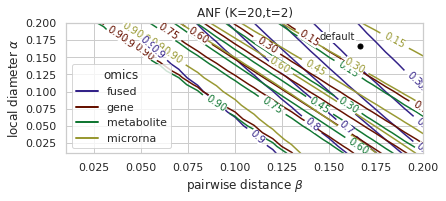

In [68]:
plt.figure(figsize=(6.4,2.4))
plt.title('ANF (K=20,t=2)')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#332288", lw=2),
                Line2D([0], [0], color="#661100", lw=2),
                Line2D([0], [0], color="#117733", lw=2),
                Line2D([0], [0], color="#999933", lw=2)]

index = alphas * len(betas)

data = pd.melt(parameters, var_name='beta').set_index(pd.Series(index))
data.index = data.index.set_names(['alpha'])
data = data.reset_index()

cs = plt.contour(betas,alphas,parameters.values, colors="#332288")
cs_gene = plt.contour(betas,alphas,parameters_gene.values, colors="#661100")
cs_metabolite = plt.contour(betas,alphas,parameters_metabolite.values, colors="#117733")
cs_microrna = plt.contour(betas,alphas,parameters_microrna.values, colors="#999933")

cgenes = plt.clabel(cs_gene, cs_gene.levels, inline=True, manual=[(0.0,0.0),(0.14,0.18),(0.12,0.18),(0.9,0.175),(0.08,0.18),(0.06,0.17),(0.04,0.175),(0.0,0.0)], fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cgenes]
cmetabolites = plt.clabel(cs_metabolite, cs_metabolite.levels, inline=True, fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cmetabolites]
cmicrorna = plt.clabel(cs_microrna, cs_microrna.levels, inline=True, manual=[(0.0,0.0),(0.185,0.175),(0.165,0.145),(0.145,0.145),(0.125,0.145),(0.0,0.0),(0.0,0.0),(0.0,0.0)], fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cmicrorna]
cfused = plt.clabel(cs, cs.levels, inline=True, manual=[(0.0,0.0),(0.6,0.15),(0.8,0.08),(0.8,0.08),(0.7,0.08),(0.16,0.05),(0.14,0.05),(0.11,0.03),(0.0,0.0)], fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in cfused]
plt.yticks([0.025, 0.050, 0.075, 0.100,0.125,0.150,0.175,0.2])
plt.xlabel('pairwise distance $\\beta$')
plt.ylabel('local diameter $\\alpha$')
plt.plot([0.1666],[0.1666], marker='o', markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.annotate('default', (0.145, 0.175), bbox=dict(facecolor='white', edgecolor='white', pad=0))
plt.legend([custom_lines[0], custom_lines[1], custom_lines[2], custom_lines[3]], ['fused', 'gene', 'metabolite', 'microrna'], title='omics', loc='lower left')
plt.savefig('../figures/ANF_modularity_K=20_t=2_alpha_beta.png', dpi=500, bbox_inches='tight')
plt.show()

### How does the number of diffusion steps affect the algebraic connectivity?

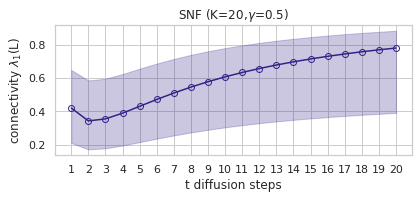

In [7]:
plt.figure(figsize=(6.4,2.4))
plt.title('SNF (K=20,$\gamma$=0.5)')

with open('../results/ts_SNF.pkl', 'rb') as f:
    ts = pickle.load(f)

with open('../results/lambda_1_t_SNF.pkl', 'rb') as f:
    lambda_1 = pickle.load(f)

# Cheeger's inequalities
lower = [lamb/2 for lamb in lambda_1]
upper = [np.sqrt(1*lamb) for lamb in lambda_1]

plt.fill_between(x=ts,y1=lower,y2=upper, color="#332288",alpha=0.25)
plt.plot(ts,lambda_1, color="#332288", marker='o', markerfacecolor="None", label='SNF')

plt.xticks(ts)
plt.ylabel('connectivity $\lambda_1$(L)')
plt.xlabel('t diffusion steps')
plt.savefig('../figures/SNF_convergence_K=20_gamma=0.5_t.png', dpi=500, bbox_inches='tight')
plt.show()

A small eigenvalue means we expect tight clusters and rather small cuts.